# Systemic Risk Prediction with Multilayer Networks


## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

# Import our custom modules
from src.data_manager import DataManager
from src.multilayer_network import MultilayerNetwork
from src.feature_extractor import FeatureExtractor
from src.gnn_model import GNNModel
from src.systemic_risk_predictor import SystemicRiskPredictor
from src.visualizer import Visualizer

from matplotlib import style

print(plt.style.available)
#lets use seaborn-v0_8-whitegrid
style.use('seaborn-v0_8-deep')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Data Loading and Preprocessing

In [2]:
# Define the path to your data directory
DATA_DIR = "data/raw_data"

# Initialize and run the data manager pipeline
data_manager = DataManager(DATA_DIR)
data_manager.run_pipeline()

# Get the processed data
data = data_manager.get_data()

Date ranges per sector:
basic_industries: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-09 00:00:00'))
capital_goods: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-08 00:00:00'))
consumer_durables: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-08 00:00:00'))
consumer_non_durables: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-12 00:00:00'))
energy: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-08 00:00:00'))
equity_final_finance: (Timestamp('2000-01-03 00:00:00'), Timestamp('2014-05-08 00:00:00'))
finance: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-08 00:00:00'))
health_care: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-08 00:00:00'))
miscellaneous: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-08 00:00:00'))
public_utilities: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-09 00:00:00'))
technology: (Timestamp('2006-01-04 00:00:00'), Timestamp('2014-05-08 00:00:00'))
transportation: (Timestamp('2006-01-04 00:00:

Let's examine what our data looks like:


Data shapes:
Raw data shape: (2100, 1210)
Log returns shape: (2099, 1210)
Training data shape: (1679, 1210)
Test data shape: (420, 1210)
Number of tickers: 1210

Sector distribution:
Sector
finance                  215
equity_final_finance     172
technology               149
capital_goods            133
health_care              117
basic_industries          89
consumer_non_durables     84
public_utilities          75
energy                    65
consumer_durables         53
miscellaneous             30
transportation            28
Name: count, dtype: int64


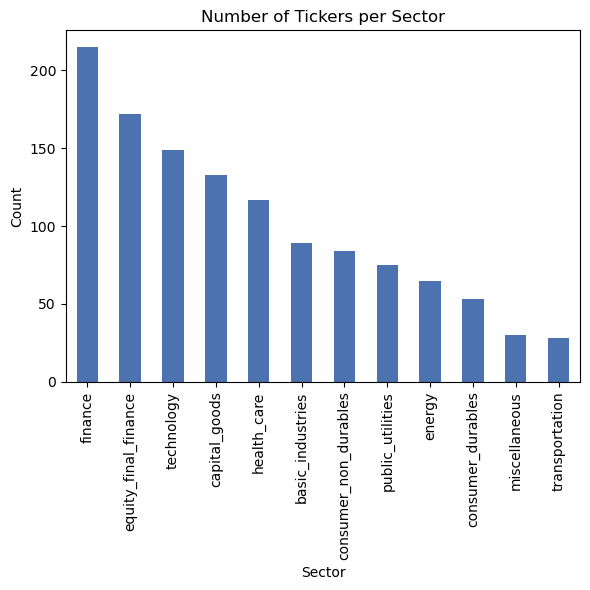

In [3]:
# Explore the data
print("Data shapes:")
print(f"Raw data shape: {data['raw_data'].shape}")
print(f"Log returns shape: {data['log_returns'].shape}")
print(f"Training data shape: {data['training_data'].shape}")
print(f"Test data shape: {data['test_data'].shape}")
print(f"Number of tickers: {len(data['tickers'])}")

# Look at sector distribution
sector_distribution = data['sector_mapping']['Sector'].value_counts()
print("\nSector distribution:")
print(sector_distribution)

# Plot sector distribution
plt.figure(figsize=(6, 6))
sector_distribution.plot(kind='bar')
plt.title('Number of Tickers per Sector')
plt.ylabel('Count')
plt.xlabel('Sector')
plt.xticks(rotation=90)
plt.tight_layout()

## Building the Multilayer Network
Next, we'll construct the multilayer network where each layer represents a different industry sector, and nodes within a layer represent individual assets (tickers)

In [4]:
# Initialize the multilayer network
network = MultilayerNetwork(
    log_returns=data['log_returns'],
    sector_mapping=data['sector_mapping'],
    window_size=200,  # 200-day window for each snapshot
    threshold=0.5,    # Correlation threshold for intra-layer edges
    inter_threshold=0.3  # Correlation threshold for inter-layer edges
)

# Check if pre-computed networks exist
if os.path.exists("results/snapshots.pkl"):
    print("Loading pre-computed network snapshots...")
    network.load_snapshots("results")
else:
    print("Building network snapshots...")
    # Create results directory if it doesn't exist
    os.makedirs("results", exist_ok=True)
    # Build the network snapshots
    network.build_network()
    # Save the snapshots for future use
    network.save_snapshots("results")

print(f"Built {len(network.networks)} network snapshots.")

Loading pre-computed network snapshots...
Loaded 136 snapshots from results/snapshots.pkl
Loaded centrality measures from results/centrality_measures.pkl
Built 136 network snapshots.


Let's visualize one of the network snapshots:

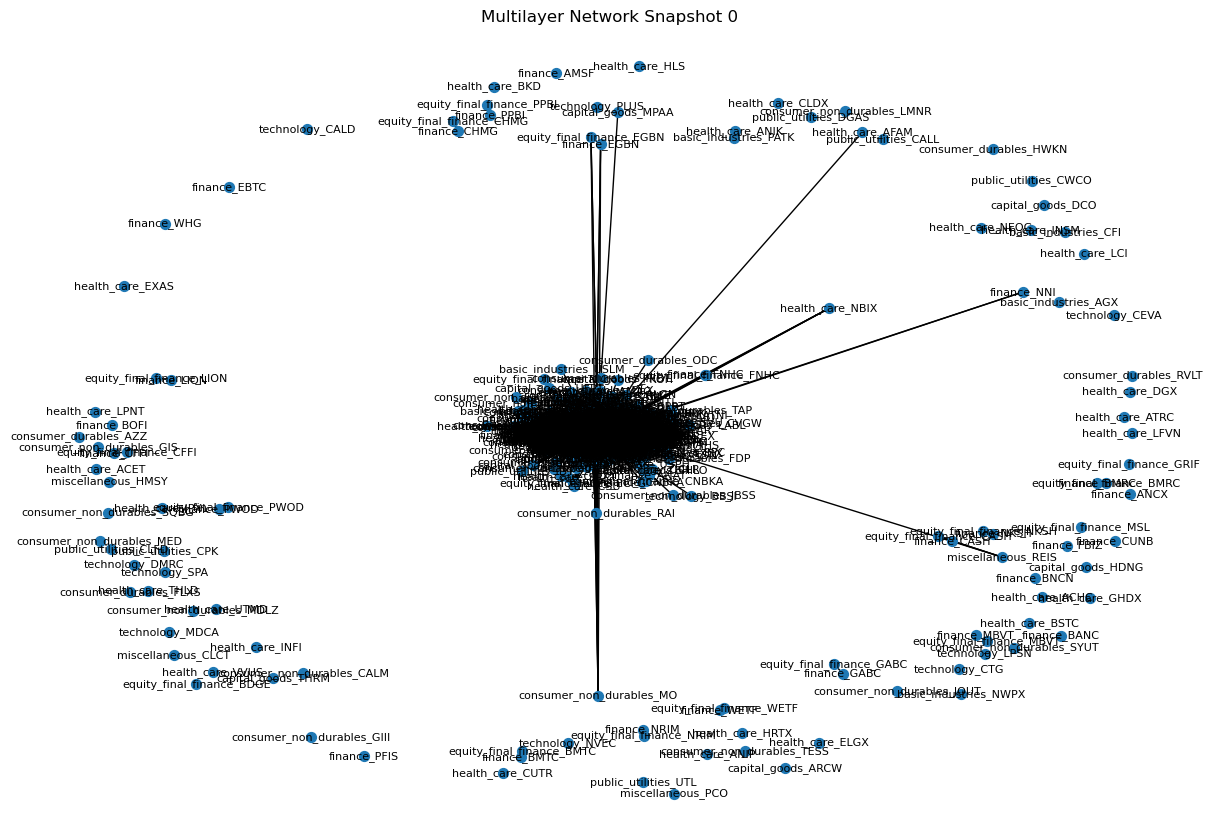

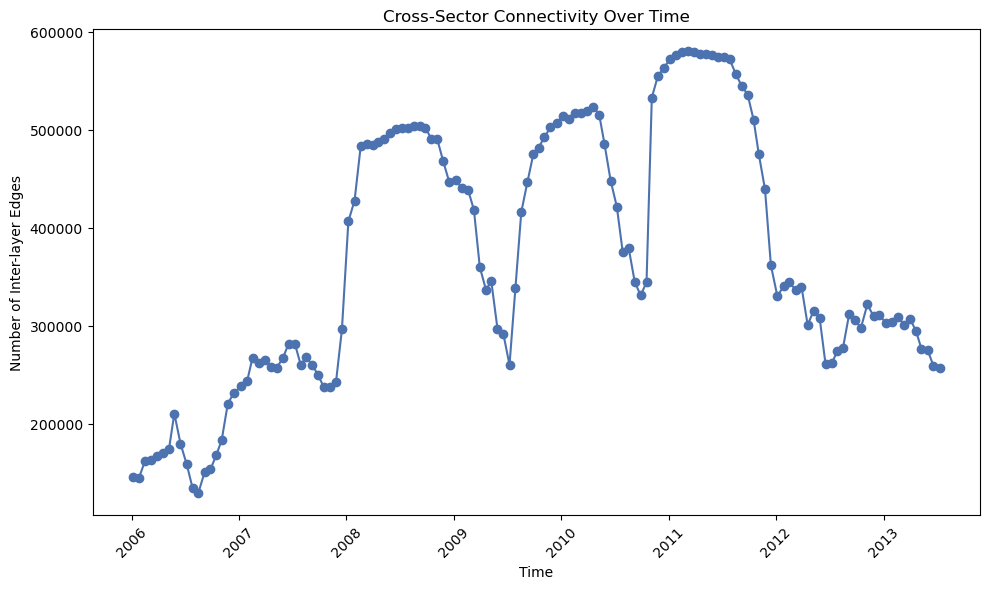

In [5]:
# Initialize the visualizer with dummy predictions for now
dummy_predictions = [0] * len(network.networks)
dummy_actuals = [0] * len(network.networks)
visualizer = Visualizer(network, dummy_predictions, dummy_actuals)

# Plot the first network snapshot
visualizer.plot_network(snapshot_index=0)

# Plot network connectivity over time
visualizer.plot_connectivity()

## Feature Extraction

Now, we'll extract both network-based and financial features from our multilayer network snapshots

In [6]:
# Initialize and run the feature extractor
feature_extractor = FeatureExtractor(network)
feature_extractor.compute_centrality()
feature_extractor.compute_financial_indicators()

# Combined features dictionary
combined_features = {}

# Loop through each snapshot and combine centrality and financial features
for idx in feature_extractor.centrality_features.keys():
    # Get all nodes that have either centrality or financial features
    all_nodes = set(feature_extractor.centrality_features[idx].keys()) | set(feature_extractor.financial_features.get(idx, {}).keys())
    
    # Initialize features for this snapshot
    snapshot_features = {}
    for node in all_nodes:
        node_features = []
        
        # Get centrality features (degree, eigenvector, clustering)
        cent_feats = feature_extractor.centrality_features[idx].get(node, {})
        node_features.append(cent_feats.get('degree', 0))
        node_features.append(cent_feats.get('eigenvector', 0))
        node_features.append(cent_feats.get('clustering', 0))
        
        # Get financial features (mean_return, volatility)
        fin_feats = feature_extractor.financial_features.get(idx, {}).get(node, {})
        node_features.append(fin_feats.get('mean_return', 0))
        node_features.append(fin_feats.get('volatility', 0))
        
        snapshot_features[node] = node_features
    
    combined_features[idx] = snapshot_features

# Store the combined features
feature_extractor.features = combined_features

print(f"Extracted features for {len(feature_extractor.features)} snapshots.")

Extracted features for 136 snapshots.


## Systemic Risk Calculation - DebtRank
Next, we'll compute the DebtRank, a measure of systemic risk, for each network snapshot:

Computed DebtRank for 136 snapshots.


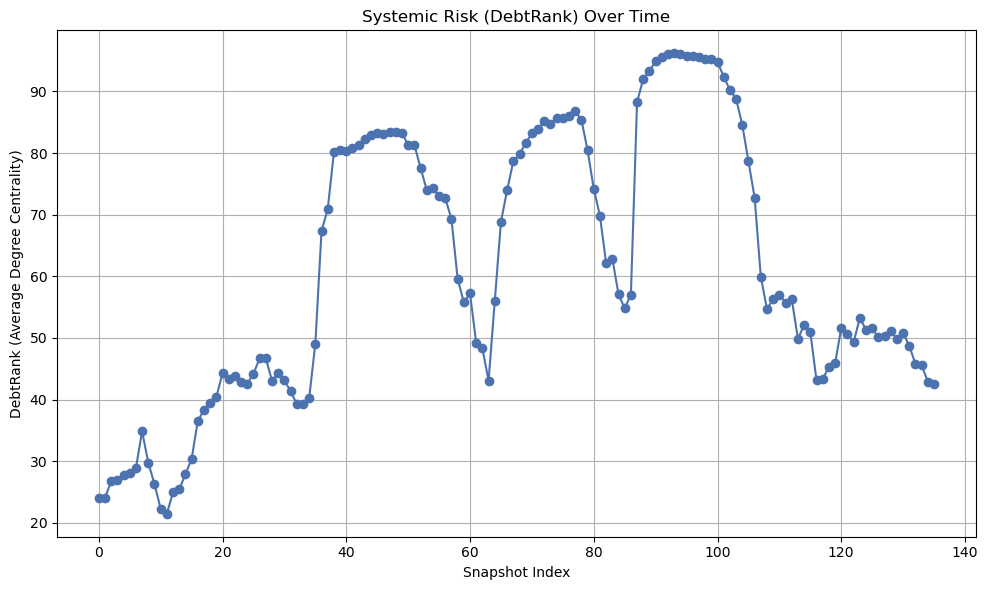

In [7]:
# Initialize the systemic risk predictor with a placeholder kernel
predictor = SystemicRiskPredictor(None, network)

# Compute DebtRank for each snapshot
predictor.compute_debtrank()

# Visualize the DebtRank values over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(predictor.debtrank)), predictor.debtrank, marker='o', linestyle='-')
plt.xlabel("Snapshot Index")
plt.ylabel("DebtRank (Average Degree Centrality)")
plt.title("Systemic Risk (DebtRank) Over Time")
plt.grid(True)
plt.tight_layout()

## GNN Model Training
Now, we'll train a Graph Neural Network (GNN) model to learn embeddings for each network snapshot

In [8]:
# Initialize the GNN model
gnn_model = GNNModel(
    in_channels=5,  # 5 features per node (3 centrality + 2 financial)
    hidden_channels=16,
    out_channels=16,
    epochs=2,  # Increase for better results
    lr=0.01
)

# Convert network snapshots to PyTorch Geometric format
gnn_model.convert_to_pyg(network, feature_extractor.features)

# Train the GNN model
gnn_model.train_gnn(predictor.debtrank)

# Get the learned embeddings
embeddings = gnn_model.get_embeddings()
print(f"Generated embeddings shape: {embeddings.shape}")

Using:  mps
Using feature dimension: 5
Converted 136 snapshots to PyG format.


/Users/angelor/MSc Computational Finance UCL/TERM2/Data Science/oop_final_data_science/src/gnn_model.py:177: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_pred.squeeze(), y_true)


training 0
training 1
training 2
training 3
training 4
training 5
training 6
training 7
training 8
training 9
training 10
training 11
training 12
training 13
training 14
training 15
training 16
training 17
training 18
training 19
training 20
training 21
training 22
training 23
training 24
training 25
training 26
training 27
training 28
training 29
training 30
training 31
training 32
training 33
training 34
training 35
training 36
training 37
training 38
training 39
training 40
training 41
training 42
training 43
training 44
training 45
training 46
training 47
training 48
training 49
training 50
training 51
training 52
training 53
training 54
training 55
training 56
training 57
training 58
training 59
training 60
training 61
training 62
training 63
training 64
training 65
training 66
training 67
training 68
training 69
training 70
training 71
training 72
training 73
training 74
training 75
training 76
training 77
training 78
training 79
training 80
training 81
training 82
training 83
tr

## Graph Kernel Computation
We'll also compute a graph kernel (Weisfeiler-Lehman) to capture the structural similarity between different network snapshots

WL kernel computed: (136, 136)
WL kernel matrix shape: (136, 136)


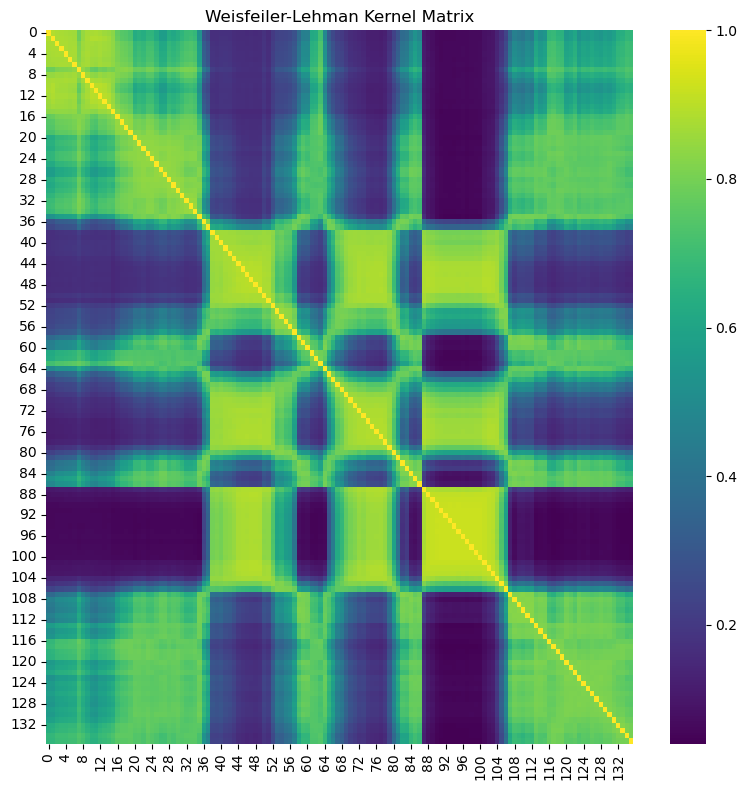

In [9]:
# Compute the WL kernel
try:
    gnn_model.compute_wl_kernel(n_iter=10)
    print(f"WL kernel matrix shape: {gnn_model.wl_kernel_matrix.shape}")
    
    # Visualize the kernel matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(gnn_model.wl_kernel_matrix, cmap='viridis')
    plt.title("Weisfeiler-Lehman Kernel Matrix")
    plt.tight_layout()
except Exception as e:
    print(f"Error computing WL kernel: {e}")
    print("Using RBF kernel on GNN embeddings instead.")
    
    # Compute RBF kernel on GNN embeddings
    from sklearn.metrics.pairwise import rbf_kernel
    rbf_kernel_matrix = rbf_kernel(embeddings, gamma=1.0)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(rbf_kernel_matrix, cmap='viridis')
    plt.title("RBF Kernel on GNN Embeddings")
    plt.tight_layout()

## Systemic Risk Prediction using SVR
Finally, we'll use Support Vector Regression (SVR) with our precomputed kernel to predict systemic risk

Computed DebtRank for 136 snapshots.
Test RMSE: 1.8296
Test Spearman Correlation: 0.9721


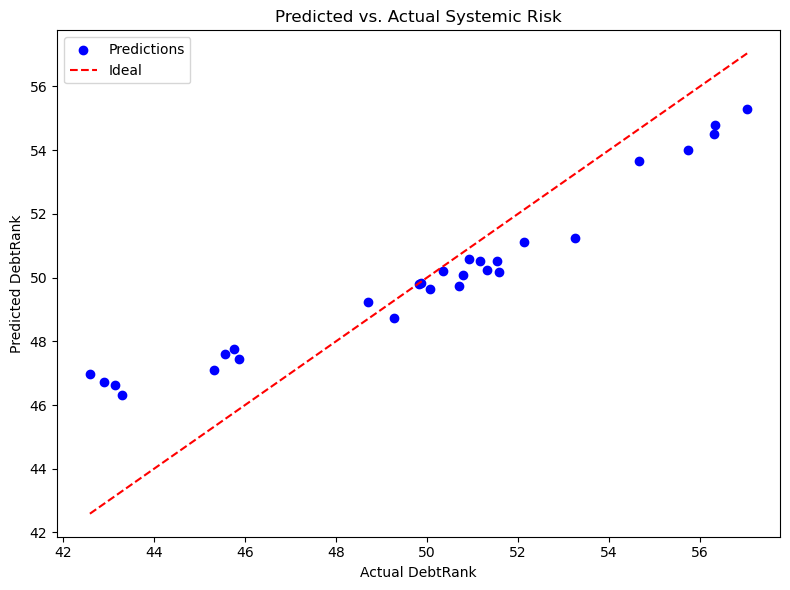

In [10]:
# Prepare the kernel matrix for SVR
kernel_matrix = getattr(gnn_model, 'wl_kernel_matrix', None)
if kernel_matrix is None:
    # Fall back to RBF kernel if WL kernel computation failed
    from sklearn.metrics.pairwise import rbf_kernel
    kernel_matrix = rbf_kernel(embeddings, gamma=1.0)

# Initialize the predictor with the kernel matrix
predictor = SystemicRiskPredictor(kernel_matrix, network)
predictor.compute_debtrank()  # Recompute DebtRank if needed

# Split data for training and testing
train_size = int(0.8 * len(predictor.debtrank))
y_train = predictor.debtrank[:train_size]
y_test = predictor.debtrank[train_size:]
K_train = kernel_matrix[:train_size, :train_size]
K_test = kernel_matrix[train_size:, :train_size]

# Train SVR on training data
from sklearn.svm import SVR
svr = SVR(kernel='precomputed')
svr.fit(K_train, y_train)

# Predict on test data
y_pred = svr.predict(K_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
spearman_corr, _ = spearmanr(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test Spearman Correlation: {spearman_corr:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal')
plt.xlabel("Actual DebtRank")
plt.ylabel("Predicted DebtRank")
plt.title("Predicted vs. Actual Systemic Risk")
plt.legend()
plt.tight_layout()

## Conclusion and Next Steps

In [11]:
# Summary of results
results = {
    'Num_Snapshots': len(network.networks),
    'Num_Features': embeddings.shape[1],
    'RMSE': rmse,
    'Spearman_Correlation': spearman_corr
}

pd.DataFrame([results]).T

,0
Num_Snapshots,136.000000
Num_Features,16.000000
RMSE,1.829578
Spearman_Correlation,0.972085
